In [1]:
import fnmatch # file name matching
import os
from scipy.io import loadmat

from pandas import DataFrame, Series
import pandas as pd
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

# Change font setting
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

# 1. Load data

In [2]:
pathname_mturk = 'mturk_DE/'
file_names_mturk = os.listdir(pathname_mturk)
print file_names_mturk

['de_col.mat', 'de_ori.mat']


In [3]:
mturk_Ori = loadmat(pathname_mturk+file_names_mturk[1])
mturk_Col = loadmat(pathname_mturk+file_names_mturk[0])
print 'Ori: ' + str(mturk_Ori.keys())
print 'Col: ' + str(mturk_Col.keys())

Ori: ['stim_ori', 'resp_ori', 'stim_col', '__header__', '__globals__', 'resp_col', '__version__']
Col: ['stim_ori', 'resp_ori', 'stim_col', '__header__', '__globals__', 'resp_col', '__version__']


In [4]:
df_stim_rOri = DataFrame(mturk_Ori['stim_ori'])
df_resp_rOri = DataFrame(mturk_Ori['resp_ori'])
df_stim_iCol = DataFrame(mturk_Ori['stim_col'])
df_resp_iCol = DataFrame(mturk_Ori['resp_col'])

df_stim_iOri = DataFrame(mturk_Col['stim_ori'])
df_resp_iOri = DataFrame(mturk_Col['resp_ori'])
df_stim_rCol = DataFrame(mturk_Col['stim_col'])
df_resp_rCol = DataFrame(mturk_Col['resp_col'])

print 'df_stim_rOri:', np.shape(df_stim_rOri)
print 'df_resp_rOri:', np.shape(df_resp_rOri)
print 'df_stim_iCol:', np.shape(df_stim_iCol)
print 'df_resp_iCol:', np.shape(df_resp_iCol)

print 'df_stim_iOri:', np.shape(df_stim_iOri)
print 'df_resp_iOri:', np.shape(df_resp_iOri)
print 'df_stim_rCol:', np.shape(df_stim_rCol)
print 'df_resp_rCol:', np.shape(df_resp_rCol)

df_stim_rOri: (600, 31)
df_resp_rOri: (600, 30)
df_stim_iCol: (600, 31)
df_resp_iCol: (600, 1)
df_stim_iOri: (600, 31)
df_resp_iOri: (600, 1)
df_stim_rCol: (600, 31)
df_resp_rCol: (600, 30)


## Orientation: remove subjects with nans (check responses): .stack() takes care of it

In [5]:
print pd.isnull(df_resp_rOri).sum().values
print pd.isnull(df_resp_rCol).sum().values

[13  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# relevant feature errors
error_rOri = (df_resp_rOri - df_stim_rOri.loc[:,:29]).stack().values #.stack().values -> reshape as single column
error_iOri = (df_resp_iOri - df_stim_iOri.loc[:,30]).stack().values

# need to take modulo of 180 (that was how input was in the experiment)
error_rOri = error_rOri % 180
error_iOri = error_iOri % 180

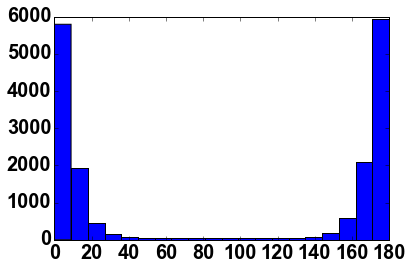

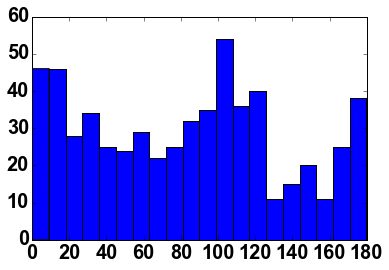

In [7]:
plt.hist(error_rOri,20)
plt.show()
plt.hist(error_iOri,20)
plt.show()

## Fix the data type of color
- Color index data is in numpy int16 format: >> type(df_stim_rCol.loc[0,0])

In [8]:
error_rCol = df_resp_rCol.stack().values.astype(int) - DataFrame(df_stim_rCol.loc[:,:29]).stack().values.astype(int)
error_iCol = df_resp_iCol.stack().values.astype(int) - DataFrame(df_stim_iCol.loc[:,30]).stack().values.astype(int)

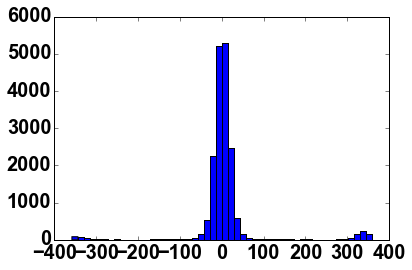

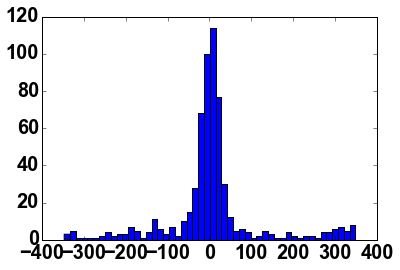

In [9]:
plt.hist(error_rCol,50)
plt.show()
plt.hist(error_iCol,50)
plt.show()

## Remap orientation and color

In [10]:
df_error_rOri = DataFrame(error_rOri)
df_error_iOri = DataFrame(error_iOri)
df_error_rCol = DataFrame(error_rCol)
df_error_iCol = DataFrame(error_iCol)

def remap(df,error_array,feature):
    if feature == 'ori':
        df[(error_array > 90) & (error_array <= 180)] = df[(error_array > 90) & (error_array <= 180)] - 180
        df[(error_array > -180) & (error_array <= -90)] = df[(error_array > -180) & (error_array <= -90)] + 180
    else:
        df[(error_array > 180) & (error_array <= 360)] = df[(error_array > 180) & (error_array <= 360)] - 360
        df[(error_array > -360) & (error_array <= -180)] = df[(error_array > -360) & (error_array <= -180)] + 360
    return np.hstack(df.values) # need hstack to flatten arrays of array to 1-D array

error_rOri_vec = remap(df_error_rOri,error_rOri,'ori')
error_iOri_vec = remap(df_error_iOri,error_iOri,'ori')
error_rCol_vec = remap(df_error_rCol,error_rCol,'col')
error_iCol_vec = remap(df_error_iCol,error_iCol,'col')

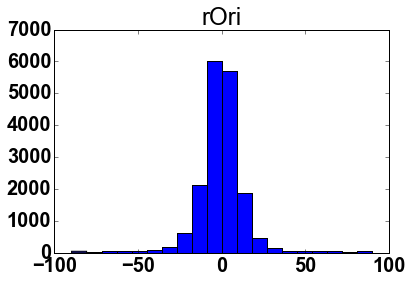

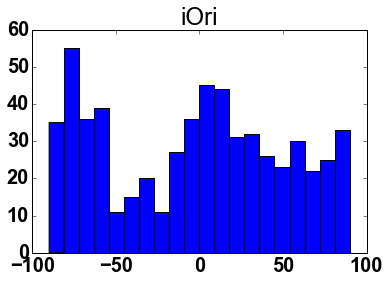

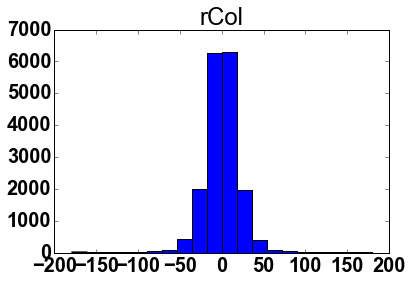

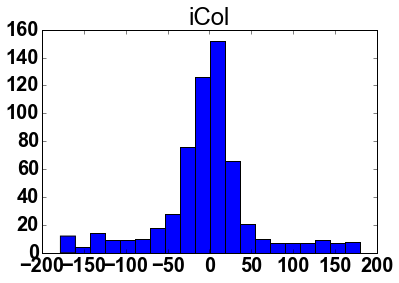

In [11]:
plt.hist(error_rOri_vec,20)
plt.title('rOri')
plt.show()

plt.hist(error_iOri_vec,20)
plt.title('iOri')
plt.show()

plt.hist(error_rCol_vec,20)
plt.title('rCol')
plt.show()

plt.hist(error_iCol_vec,20)
plt.title('iCol')
plt.show()

# 2. Circular statistics
1. Only works with scale [-pi, pi]
2. compute the length (R), and use it to compute csd
3. rescale back to the original range

In [12]:
def degtorad(deg):
    return deg*np.pi/180;

def radtodeg(rad):
    return rad*180/np.pi;

def cart2pol(x, y):
    theta = np.arctan2(y, x) # arctan2 returns angle
    rho = np.sqrt(x**2 + y**2)
    return theta, rho

def circ_std(degvec,feature):
    """Compute circular standard deviation"""
    
    # convert deg to rad
    radvec = degtorad(degvec)
    
    # original range
    # ori: [-pi/2, pi/2]
    # col: [-pi, pi]
    if feature == 'ori':
        radvec = radvec*2

    # compute the length, R
    x = np.mean(np.sin(radvec));
    y = np.mean(np.cos(radvec));
    theta,R = cart2pol(x,y)
    
    # compute csd
    csd = np.sqrt(-2*np.log(R));

    # scale back if necessary
    if feature == 'ori':
        csd = csd/2
        
    return radtodeg(csd)

## Bootstrap for circular standard deviation of errors

In [13]:
import numpy.random as npr
import pylab

def feat_circ_bootstrap(data, feature, num_samples, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = npr.randint(0, n, (num_samples, n))
    samples = data[idx]

    circ_std_vec = []
    for sample in samples:        
        circ_std_vec.append(circ_std(sample,feature))
    stat = np.sort(circ_std_vec)

    return stat[int((alpha/2.0)*num_samples)], stat[int((1-alpha/2.0)*num_samples)]

In [14]:
num_samples = 10000
alpha = 0.05

datas = [error_rOri_vec,error_iOri_vec,error_rCol_vec,error_iCol_vec]
for i,data in enumerate(datas):
    if i <= 1:
        feature = 'ori'
    else:
        feature = 'col'
    low, high =  feat_circ_bootstrap(data, feature, num_samples, alpha)
    print np.round(low,decimals=1), np.round(high,decimals=1) 

13.4 14.0
60.7 83.2
22.8 23.8
47.3 56.1


## csd from raw data

In [16]:
for i,data in enumerate(datas):
    if i <= 1:
        feature = 'ori'
    else:
        feature = 'col'
    print np.round(circ_std(data,feature),decimals=1)

13.7
70.6
23.3
51.6
